In [1]:
# !pip install torch torchvision shap matplotlib seaborn scikit-learn

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Configuración de hiperparámetros
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
PATIENCE = 5  # Paciencia para early stopping
DATASET_DIR = "arcgis-survey-images"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Transformaciones de datos y carga del dataset
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=DATASET_DIR, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = datasets.ImageFolder(root=DATASET_DIR, transform=transform)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
# Definir la red neuronal
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 256 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
# Inicializar modelo, criterio y optimizador
num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes=num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [7]:
# Implementar Early Stopping
best_loss = np.inf
patience = PATIENCE
trigger_times = 0

In [8]:
# Historial para gráficos
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [9]:
for epoch in range(EPOCHS):
    # Entrenamiento
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validación
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, val_predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (val_predicted == labels).sum().item()
    
    val_loss = val_running_loss / len(validation_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{EPOCHS}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    # Early Stopping Check
    if val_loss < best_loss:
        best_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Guardar el mejor modelo
    else:
        trigger_times += 1
        print(f"Early stopping trigger times: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print("Early stopping!")
            break

Epoch 1/20, Train Loss: 1.3037, Train Accuracy: 47.33%, Val Loss: 0.9194, Val Accuracy: 69.85%
Epoch 2/20, Train Loss: 0.9098, Train Accuracy: 68.46%, Val Loss: 0.8337, Val Accuracy: 71.40%
Epoch 3/20, Train Loss: 0.7580, Train Accuracy: 75.51%, Val Loss: 0.6121, Val Accuracy: 81.38%
Epoch 4/20, Train Loss: 0.6735, Train Accuracy: 77.64%, Val Loss: 0.6452, Val Accuracy: 80.58%
Early stopping trigger times: 1/5
Epoch 5/20, Train Loss: 0.6064, Train Accuracy: 80.47%, Val Loss: 0.4928, Val Accuracy: 83.67%
Epoch 6/20, Train Loss: 0.5506, Train Accuracy: 82.23%, Val Loss: 0.4509, Val Accuracy: 84.42%
Epoch 7/20, Train Loss: 0.4984, Train Accuracy: 83.40%, Val Loss: 0.4690, Val Accuracy: 85.54%
Early stopping trigger times: 1/5
Epoch 8/20, Train Loss: 0.4907, Train Accuracy: 82.92%, Val Loss: 0.3765, Val Accuracy: 87.73%
Epoch 9/20, Train Loss: 0.4014, Train Accuracy: 85.33%, Val Loss: 0.3497, Val Accuracy: 88.53%
Epoch 10/20, Train Loss: 0.3653, Train Accuracy: 87.94%, Val Loss: 0.3187, Va

In [10]:
# Cargar el mejor modelo (si se activó el early stopping)
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

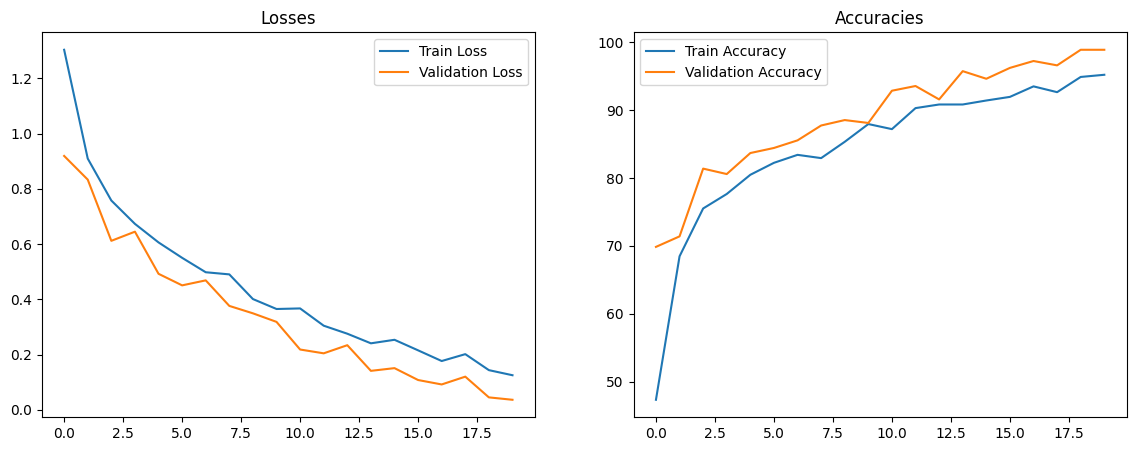

In [11]:
# Graficar las pérdidas y las precisiones
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracies')

plt.show()